In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
import seaborn as sns
import pymc as pm
import multiprocessing
import arviz as az
import warnings
import sys

sys.path.append(os.path.abspath(os.path.join("../")))

from src.evaluate import ams_score, report_metrics

# --- Reproducibility setup ---
SEED = 1

np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
pm.set_data = getattr(pm, "set_data", lambda *args, **kwargs: None)

# --- Warning filters ---
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Load data

In [2]:
# Load preprocessed data
train_preprocess = pd.read_csv("../data/processed/train_preprocess.csv")
test_preprocess = pd.read_csv("../data/processed/test_preprocess.csv")

# Separate features and labels
X_train = train_preprocess.drop(["Weight", "Label"], axis=1)
X_test = test_preprocess.drop(["Weight", "Label"], axis=1)
y_train = train_preprocess["Label"]
y_test = test_preprocess["Label"]

# Extract weights
weights_train = train_preprocess["Weight"]
weights_test = test_preprocess["Weight"]

print("Data loaded successfully:")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Data loaded successfully:
X_train shape: (589448, 17)
X_test shape: (104188, 17)


# Bayesian logistic regression model


In [3]:
# If dataset is huge, MCMC may be slow. We'll sample a reasonable subset, preserving class balance.
max_train_samples = 100000
feature_names = list(X_train.columns)

if X_train.shape[0] > max_train_samples:
    # stratified sampling
    train_df = X_train.copy()
    train_df["y"] = y_train
    train_small = train_df.groupby("y").sample(n=int(max_train_samples / 2), random_state=42)
    X_bayes = train_small[feature_names].values
    y_bayes = train_small["y"].values
    print("Using subsample for MCMC:", X_bayes.shape)
else:
    X_bayes = X_train.values
    y_bayes = y_train.values
    print("Using full training set for MCMC:", X_bayes.shape)

Using subsample for MCMC: (100000, 17)


In [ ]:
"""
Train Bayesian LogReg. Computationally expensive. Skip this chunck to just load the model saved in models/
"""
n_samples, n_features = X_bayes.shape

with pm.Model() as bayesian_logistic_model:
    # --- Priors ---
    # Define priors based on Gelman et al. (2008) 
    # Intercept: Cauchy(0, 10) or StudentT(nu=1, mu=0, sigma=10)
    intercept = pm.StudentT('intercept', nu=1, mu=0, sigma=10)
    
    # Coefficients: Cauchy(0, 2.5) or StudentT(nu=1, mu=0, sigma=2.5)
    betas = pm.StudentT('betas', nu=1, mu=0, sigma=2.5, 
                       shape=n_features, dims="features")
    
    # --- Linear Predictor ---
    # The linear combination (log-odds, or eta)
    eta = intercept + pt.dot(X_bayes, betas)
    
    # --- Likelihood ---
    # We model the observed data y_train as a Bernoulli trial.
    # We use 'logit_p=eta' which is the numerically stable
    # way to specify a Bernoulli likelihood with a logit link.
    y_obs = pm.Bernoulli('y_obs', logit_p=eta, observed=y_bayes)
    
    # --- Inference (Sampling) ---
    # Use NUTS sampler to draw from the posterior
    print("Starting MCMC sampling...")
    trace = pm.sample(2000, tune=1000, chains=4, cores=4, 
                      target_accept=0.9,
                      idata_kwargs={'log_likelihood': True})
    print("Sampling complete.")
# --- Model Diagnostics ---
# R-hat should be < 1.01 for all parameters to indicate convergence
summary = az.summary(trace, var_names=['intercept', 'betas'])
print(summary)

# Save the trace for later analysis
trace.to_netcdf("../models/bayesian_logreg_trace.nc")

Starting MCMC sampling...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [intercept, betas]


Output()

Sampling 1 chain for 1_000 tune and 1_322 draw iterations (1_000 + 1_322 draws total) took 1085 seconds.


In [ ]:
# Load the model
trace = az.from_netcdf("../models/bayesian_logreg_trace.nc")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.146,0.073,0.001,0.285,0.001,0.001,9302.0,5830.0,1.0
betas[0],0.628,0.163,0.314,0.945,0.002,0.002,5912.0,5889.0,1.0
betas[1],0.629,0.101,0.442,0.830,0.001,0.001,6647.0,5662.0,1.0
betas[2],-0.514,0.274,-1.023,0.036,0.004,0.003,4848.0,5551.0,1.0
betas[3],-0.803,0.176,-1.150,-0.464,0.002,0.002,5615.0,5952.0,1.0
betas[4],0.221,0.086,0.054,0.386,0.001,0.001,8848.0,6049.0,1.0
betas[5],0.587,0.219,0.165,1.021,0.003,0.002,5464.0,5111.0,1.0
betas[6],0.254,0.196,-0.137,0.633,0.003,0.002,5575.0,5285.0,1.0
betas[7],-0.389,0.093,-0.574,-0.212,0.001,0.001,7760.0,6333.0,1.0
betas[8],-0.622,0.170,-0.965,-0.303,0.002,0.002,6112.0,5864.0,1.0


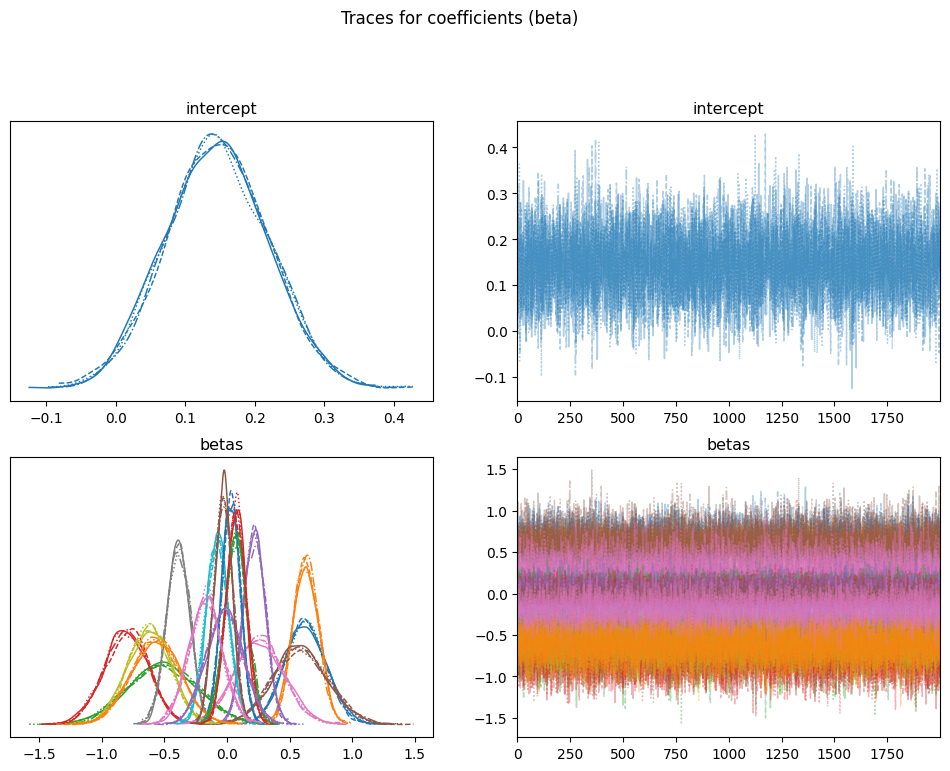

In [ ]:
# Plot coefficient traces
subset_beta_idx = list(range(n_features))
az.plot_trace(trace, var_names=["intercept", "betas"], coords={"features": subset_beta_idx}, figsize=(12, 8))
plt.suptitle("Traces for coefficients (beta)", y=1.02)

# Posterior summary numeric
summary_df = az.summary(trace, var_names=["intercept", "betas"], hdi_prob=0.95)
display(summary_df)

## Posterior predictive checks & predictive performance

We approximate predictive probabilities on the test set using posterior samples:
- use posterior samples of `alpha` and `beta` to compute predictive probabilities for each test point (posterior predictive mean)
- compute ROC AUC from posterior predictive mean
- compare with baseline logistic regression

In [ ]:
# Posterior predictive probabilities on test set (approximate with Monte Carlo)
# Get posterior samples arrays
posterior = trace.posterior
beta_samples = posterior["beta"].stack(sample=("chain", "draw")).values
alpha_samples = posterior["alpha"].stack(sample=("chain", "draw")).values.flatten()
beta_all = beta_samples
alpha_all = alpha_samples

# Use all posterior samples for predictions (may be large)
n_post_samples = beta_all.shape[1]
print("Posterior draws available:", n_post_samples)

# Convert X_test to numpy
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test


# compute p(y=1 | x, posterior) approximated by sigmoid(alpha_s + x @ beta_s) averaged over posterior draws
# we vectorize in chunks to avoid memory spikes
def posterior_predictive_proba(X, alpha_samps, beta_samps, chunk=1000):
    n_samples = beta_samps.shape[1]
    probs_accum = np.zeros((X.shape[0],))
    # iterate over posterior draws in chunks
    for i in range(0, n_samples, chunk):
        b = beta_samps[:, i : i + chunk]
        a = alpha_samps[i : i + chunk]
        # compute linear predictors for chunk: X @ b
        lin = X @ b
        lin = lin + a  # broadcasts
        probs_chunk = 1 / (1 + np.exp(-lin))
        probs_accum += probs_chunk.mean(axis=1) * (chunk / n_samples)
    return probs_accum


# safe chunking: choose chunk size so we exactly weight average
posterior_mean_proba = posterior_predictive_proba(X_test_np, alpha_all, beta_all, chunk=200)

auc_bayes = roc_auc_score(y_test, posterior_mean_proba)
print(f"Bayesian logistic (posterior mean predictive) AUC: {auc_bayes:.4f}")

# Threshold posterior mean probability at 0.5
y_pred_bayes = (posterior_mean_proba >= 0.5).astype(int)

# Ensure true labels
y_test_num = np.where(y_test == "s", 1, 0).astype(int)

# Accuracy
acc_bayes = accuracy_score(y_test_num, y_pred_bayes)
print(f"Bayesian Logistic Regression Accuracy: {acc_bayes:.4f}")

# Classification report
print("Bayesian Logistic Regression Classification Report:")
print(classification_report(y_test_num, y_pred_bayes, target_names=["b", "s"]))

Posterior draws available: 4000
Bayesian logistic (posterior mean predictive) AUC: 0.7655
Bayesian Logistic Regression Accuracy: 0.6603
Bayesian Logistic Regression Classification Report:
              precision    recall  f1-score   support

           b       0.85      0.54      0.66     84515
           s       0.54      0.85      0.66     54213

    accuracy                           0.66    138728
   macro avg       0.70      0.69      0.66    138728
weighted avg       0.73      0.66      0.66    138728



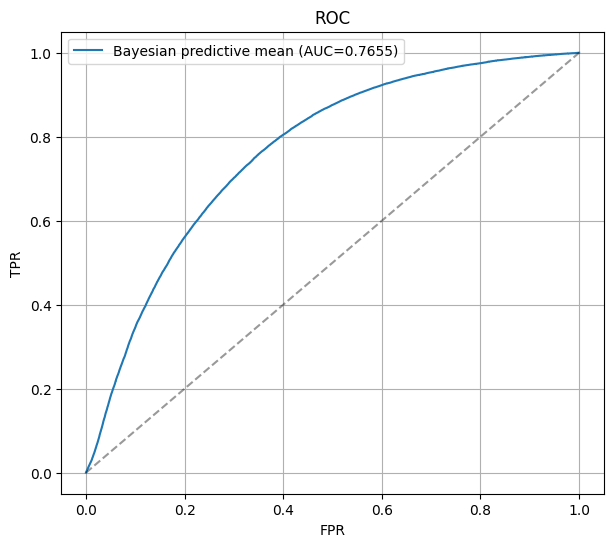

In [ ]:
# ROC curve
fpr_b, tpr_b, _ = roc_curve(y_test, posterior_mean_proba, pos_label="s")

plt.figure(figsize=(7, 6))
plt.plot(fpr_b, tpr_b, label=f"Bayesian predictive mean (AUC={auc_bayes:.4f})")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()
plt.grid(True)